## Linear biomechanical model
A linear biomechanical model simulating the mouse elbow joint. Model parameters are estimated based on the mouse forelimb. Joint excursion is constrained by exponential elastic stops. Small viscosity is added to improve the stability of the system, which is necessary for the elastic stops to work appropriately.  

###  Load libraries

In [4]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
device = 'cpu'

###  Define simulation parameters

In [5]:
Fs = 10000
h = 1/Fs
duration = 1

### Define inputs 
* u_1: input to flexor 
* u_2: input to extensor

In [6]:
# Set the amplitude of step inputs
u_1_amp = 0
u_2_amp = 1

# Generate step inputs to flexor and extensor
time_sim = torch.arange(0,duration,step = 1/Fs,dtype=torch.double).to(device)
u_1 = torch.zeros([int(duration*Fs),1],dtype=torch.double).to(device)
u_2 = torch.zeros([int(duration*Fs),1],dtype=torch.double).to(device)
u_1[int(0.1*Fs):] = u_1_amp
u_2[int(0.1*Fs):] = u_2_amp

### Define parameters of the biomechanical model

In [9]:
# Segment length
L = 0.015 
# Distance between the rotational axis and the center of the segment 
d = 0.015/2-0.005
# Segment mass
M = 0.00020154
# Segment inertia
I = 1/12.0*np.power(L,2)*M + np.power(d,2)*M
# Stiffness
K = 0.0
# Viscosity 
B = 0.00001

# Minimum joint angle
theta_min = 20*np.pi/180.0
# Maximum joint angle
theta_max = 150*np.pi/180.0

# Maximum muscle force (N)
F0 = 1
# Muscle time constant (ms)
tau_1 = 0.005;
tau_2 = 0.005;
# Moment arm (m)
r_m1 = 0.002
r_m2 = -0.002

### Initialize parameters
* x: state vector
<br>
x[0]: joint angle
<br>
x[1]: joint angular velocity
<br>
x[2]: flexor muscle force 
<br>
x[3]: its derivatve
<br>
x[4]: extensor muscle force
<br>
x[5]: its derivative
* u: input vector
<br>
u[0]: input to flexor 
<br>
u[1]: input to extensor

In [8]:
x = torch.tensor([90*np.pi/180,0,0,0,0,0],dtype = torch.double).to(device)
u = torch.zeros([2],dtype = torch.double).to(device)

### Define state and input matrices and torque vector for joint constraints 

In [10]:
A_mat = torch.tensor([[0,1,0,0,0,0],
                      [-K/I,-B/I,r_m1*F0/I,0,r_m2*F0/I,0],
                      [0,0,-1/tau_2,1/tau_2,0,0],
                      [0,0,0,-1/tau_1,0,0],
                      [0,0,0,0,-1/tau_2,1/tau_2],
                      [0,0,0,0,0,-1/tau_1]],dtype = torch.double).to(device)
B_mat = torch.tensor([[0,0],
                      [0,0],
                      [0,0],
                      [1/tau_1,0],
                      [0,0],
                      [0,1/tau_1]],dtype = torch.double).to(device)
T_stop = torch.zeros([6],dtype = torch.double).to(device)

### Variables to store data

In [12]:
x_mat = torch.empty(0, dtype=torch.double).to(device)
u_mat = torch.empty(0, dtype=torch.double).to(device)

### Start forward simulations 

In [13]:
t0 = time.time()
for t in range(int(duration*Fs)):
    u[0] = u_1[t] 
    u[1] = u_2[t]
    
    
    k1 = h*(torch.mv(A_mat,x) + torch.mv(B_mat,u) + T_stop)
    k2 = h*(torch.mv(A_mat,x+k1/2) + torch.mv(B_mat,u) + T_stop)
    k3 = h*(torch.mv(A_mat,x+k2/2) + torch.mv(B_mat,u) + T_stop)
    k4 = h*(torch.mv(A_mat,x+k3) + torch.mv(B_mat,u) + T_stop)
    x = x + 1/6*(k1+2*k2+2*k3+k4)
    
    T_stop_1 = 0.01*torch.exp(-(x[0]-theta_min)/0.01)
    T_stop_2 = -0.01*torch.exp((x[0]-theta_max)/0.01)
    T_stop[1] = (T_stop_1+T_stop_2)/I
     
    x_mat =  torch.cat((x_mat,x.unsqueeze(0)),0)   
    u_mat =  torch.cat((u_mat,u.unsqueeze(0)),0)   


tf = time.time()
total = tf-t0
print(total)

3.027148485183716


### Plot data

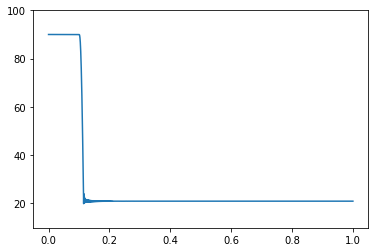

In [15]:
min_angle = np.min(np.rad2deg(x_mat[:,0].data.cpu().numpy()))
max_angle = np.max(np.rad2deg(x_mat[:,0].data.cpu().numpy()))
plt.plot(time_sim.data.cpu().numpy(),np.rad2deg(x_mat[:,0].data.cpu().numpy()))
plt.ylim([min_angle-10, max_angle+10])
plt.show()